In [1]:
# -*- coding:utf -8-*-
import operator
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import word_tokenize, wordpunct_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools

%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))

In [2]:
def tokenizator(text):
    text = text.lower()
    text = re.sub("[,;':.?!]", '', text)
    return word_tokenize(text)  

# С чем нам придётся работать

In [3]:
f = pd.read_csv("All-seasons.csv") 
f = f.drop(['Season','Episode'],1)
f.head()
Butters = (f.Character == "Butters")
Cartman = (f.Character == "Cartman")
Kyle = (f.Character == "Kyle")
Stan = (f.Character == "Stan")
chars = f[Cartman | Kyle | Stan | Butters]
chars = chars.dropna()
chars = chars.reset_index(drop=True)

Произвели подготовку датафрейма - загрузили, убрали лишнее, оставили наиболее говорящих персонажей

In [4]:
rep_train, rep_test, char_train, char_test = train_test_split(chars['Line'], chars['Character'], test_size=0.2)

In [5]:
countvec = CountVectorizer(tokenizer = word_tokenize, stop_words = "english")
train_bowed_rep = countvec.fit(rep_train)
test_bowed_rep = countvec.fit(rep_test)
train_bowed_rep = countvec.transform(rep_train)
test_bowed_rep = countvec.transform(rep_test)

fit_transform нормально работать не хочет, вызывая далее dimension mismatch. 
Стоп-слова в бой пойдут, однако обсценную лексику убирать не стоит - она значима для сериала.

In [6]:
DC = DummyClassifier(strategy='stratified', random_state=0)
DC = DC.fit(train_bowed_rep, char_train)
print(classification_report(char_test, DC.predict(test_bowed_rep)))

             precision    recall  f1-score   support

    Butters       0.10      0.10      0.10       522
    Cartman       0.37      0.36      0.36      1959
       Kyle       0.26      0.26      0.26      1418
       Stan       0.27      0.28      0.28      1532

avg / total       0.29      0.29      0.29      5431



Решил для baseline взять не most_frequent, а stratified, чтобы иметь возможность хоть как-то оценить не только Картмана, но и остальную тройку

In [7]:
naive_model = MultinomialNB()
naive_model.fit(train_bowed_rep, char_train)
pred = naive_model.predict(test_bowed_rep)
cv_results = cross_val_score(naive_model, test_bowed_rep, char_test, cv=15, scoring='accuracy')
print(classification_report(char_test, naive_model.predict(test_bowed_rep)))

             precision    recall  f1-score   support

    Butters       0.47      0.34      0.39       522
    Cartman       0.49      0.62      0.55      1959
       Kyle       0.41      0.30      0.35      1418
       Stan       0.42      0.43      0.42      1532

avg / total       0.45      0.46      0.45      5431



Интереса ради посмотрим и сравним как отличится отбалансированные и неотбалансированные классификаторы

In [8]:
forest = RandomForestClassifier()
forest.fit(train_bowed_rep, char_train) 
predicted = forest.predict(test_bowed_rep)
cv_results = cross_val_score(forest, test_bowed_rep, char_test, cv=15, scoring='accuracy')
print(classification_report(char_test, predicted)) 

             precision    recall  f1-score   support

    Butters       0.38      0.21      0.27       522
    Cartman       0.49      0.60      0.54      1959
       Kyle       0.39      0.34      0.36      1418
       Stan       0.38      0.39      0.38      1532

avg / total       0.42      0.43      0.42      5431



In [9]:
forest = RandomForestClassifier(class_weight = 'balanced')
forest.fit(train_bowed_rep, char_train) 
predicted = forest.predict(test_bowed_rep)
cv_results = cross_val_score(forest, test_bowed_rep, char_test, cv=15, scoring='accuracy')
print(classification_report(char_test, predicted)) 

             precision    recall  f1-score   support

    Butters       0.30      0.34      0.32       522
    Cartman       0.52      0.53      0.53      1959
       Kyle       0.36      0.34      0.35      1418
       Stan       0.38      0.37      0.38      1532

avg / total       0.42      0.42      0.42      5431



Кайл и Стэн в отбалансированной выборке явно распознаются хуже. 
Картман, в общем, тоже, хотя метрика Precision лучше как раз на отбалансированной выборке.
А вот в случае с Баттерсом всё зеркально. У него хуже Precision, но лучше всё остальное.
Общий результат же практически одинаков.

In [10]:
tree = DecisionTreeClassifier()
tree.fit(train_bowed_rep, char_train) 
predicted = tree.predict(test_bowed_rep)
cv_results = cross_val_score(tree, test_bowed_rep, char_test, cv=15, scoring='accuracy')
print(classification_report(char_test, predicted)) 

             precision    recall  f1-score   support

    Butters       0.29      0.22      0.25       522
    Cartman       0.49      0.53      0.51      1959
       Kyle       0.36      0.33      0.34      1418
       Stan       0.38      0.39      0.39      1532

avg / total       0.40      0.41      0.41      5431



In [11]:
tree = DecisionTreeClassifier(class_weight = 'balanced')
tree.fit(train_bowed_rep, char_train) 
predicted = tree.predict(test_bowed_rep)
cv_results = cross_val_score(tree, test_bowed_rep, char_test, cv=15, scoring='accuracy')
print(classification_report(char_test, predicted)) 

             precision    recall  f1-score   support

    Butters       0.23      0.35      0.27       522
    Cartman       0.52      0.43      0.47      1959
       Kyle       0.34      0.35      0.34      1418
       Stan       0.37      0.38      0.38      1532

avg / total       0.40      0.38      0.39      5431



Ситуация в принципе повторилась, правда результат ещё хуже

In [12]:
log = LogisticRegression()
log.fit(train_bowed_rep, char_train) 
predicted = log.predict(test_bowed_rep)
cv_results = cross_val_score(log, test_bowed_rep, char_test, cv=15, scoring='accuracy')
print(classification_report(char_test, predicted)) 

             precision    recall  f1-score   support

    Butters       0.66      0.28      0.39       522
    Cartman       0.54      0.64      0.59      1959
       Kyle       0.44      0.33      0.38      1418
       Stan       0.41      0.49      0.45      1532

avg / total       0.49      0.48      0.48      5431



In [13]:
log = LogisticRegression(class_weight = 'balanced')
log.fit(train_bowed_rep, char_train) 
predicted = log.predict(test_bowed_rep)
cv_results = cross_val_score(log, test_bowed_rep, char_test, cv=15, scoring='accuracy')
print(classification_report(char_test, predicted)) 

             precision    recall  f1-score   support

    Butters       0.40      0.48      0.43       522
    Cartman       0.61      0.56      0.59      1959
       Kyle       0.43      0.38      0.40      1418
       Stan       0.41      0.47      0.44      1532

avg / total       0.49      0.48      0.48      5431



В общем и целом, выборки проявили себя плюс-минус одинаково. Однако если смотреть на отдельных персонажей, то тут данные различаются. При прочих равных, я бы из двух регрессий выбрал бы отбалансированную, потому что она несколько ровнее определяет каждого персонажа, в ней нет такого скачка, какой есть у Баттерса в неотбалансированной регрессии.

Confusion matrix, without normalization
[[ 251   86   71  114]
 [ 140 1099  288  432]
 [ 119  286  539  474]
 [ 124  326  368  714]]
Normalized confusion matrix
[[ 0.48  0.16  0.14  0.22]
 [ 0.07  0.56  0.15  0.22]
 [ 0.08  0.2   0.38  0.33]
 [ 0.08  0.21  0.24  0.47]]


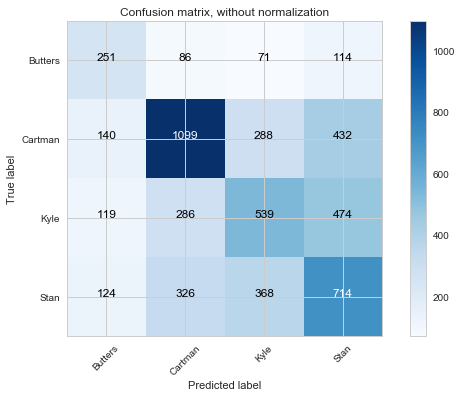

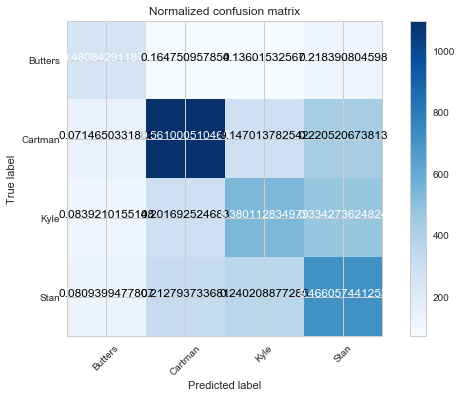

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(char_test, log.predict(test_bowed_rep))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=log.classes_,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=log.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

По матрице видно, чьл в целом персонажей особо не путают, хотя в общем-то могут принять Кайла за Стена.

# ИТОГ

Лучше всего себя показали обе регрессии, хотя я бы взял отбалансированную. Однако на самом деле это выбор из меньших зол, потому что не один классификатор не дотянулся до хотя бы 50% точности.